In [34]:
#Importamos Librerias, funciones y metricas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

In [44]:
data= pd.read_csv('winequality-red.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## Verficar Valores Nulos

In [8]:
print(data.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


## Observar algunos Datos

In [10]:
print(data.head(20))

    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0             7.4             0.700         0.00             1.9      0.076   
1             7.8             0.880         0.00             2.6      0.098   
2             7.8             0.760         0.04             2.3      0.092   
3            11.2             0.280         0.56             1.9      0.075   
4             7.4             0.700         0.00             1.9      0.076   
5             7.4             0.660         0.00             1.8      0.075   
6             7.9             0.600         0.06             1.6      0.069   
7             7.3             0.650         0.00             1.2      0.065   
8             7.8             0.580         0.02             2.0      0.073   
9             7.5             0.500         0.36             6.1      0.071   
10            6.7             0.580         0.08             1.8      0.097   
11            7.5             0.500         0.36    

## Frecuencia Absoluta Variable Objetivo

In [12]:
frecuencias = data['quality'].value_counts()

# Mostrar el resultado
print(frecuencias)

quality
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64


## Verificar Valores Atípicos

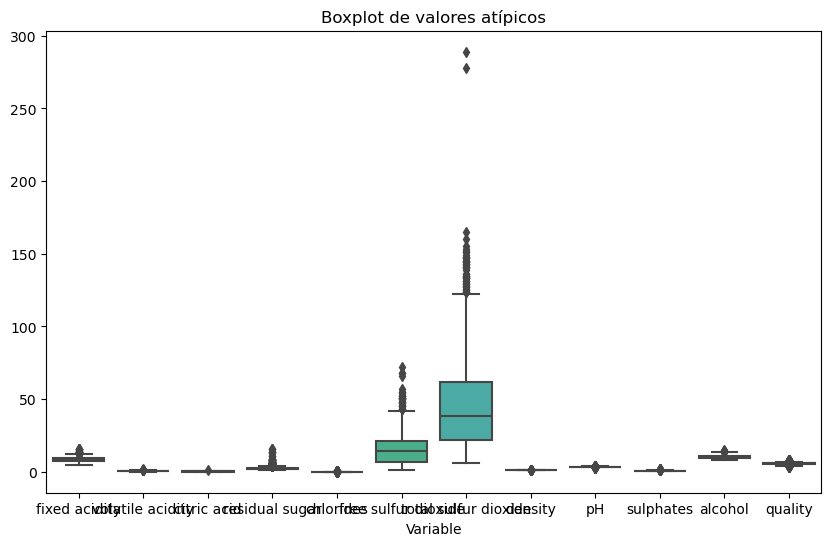

In [14]:
plt.figure(figsize=(10, 6))
#sns.boxplot(data=data.iloc[:, :1])
sns.boxplot(data=data)
plt.title('Boxplot de valores atípicos')
plt.xlabel('Variable')
plt.show()

## Tratar Valores Atípicos

In [46]:
# Define los grupos de columnas y sus umbrales, omitiendo la variable objetivo 'quality'
column_groups = {
    'grupo1': ['fixed acidity', 'volatile acidity', 'total sulfur dioxide', 'residual sugar'],  # Primer grupo
    'grupo2': ['citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'density'],  # Segundo grupo
    'grupo3': ['pH', 'sulphates', 'alcohol'],  # Tercer grupo
    # 'grupo4': ['quality']  # Omite este grupo porque es la variable objetivo
}

# Define los umbrales para cada grupo
thresholds = {
    'grupo1': 1.2,
    'grupo2': 2.3,
    'grupo3': 2.8,
    # No se necesita un umbral para la variable objetivo
}

# Llenamos valores atípicos con la media
for group, columns in column_groups.items():
    for column in columns:
        # Calcula la media y la desviación estándar de la columna
        mean = data[column].mean()
        std_dev = data[column].std()
        
        # Calcular z-scores
        z_score = (data[column] - mean) / std_dev
        
        # Establecer el umbral específico para el grupo
        threshold = thresholds[group]
        
        # Identificar valores atípicos
        outliers = data[(z_score > threshold) | (z_score < -threshold)].index
        
        # Imputar valores atípicos con la media
        data.loc[outliers, column] = round(mean)


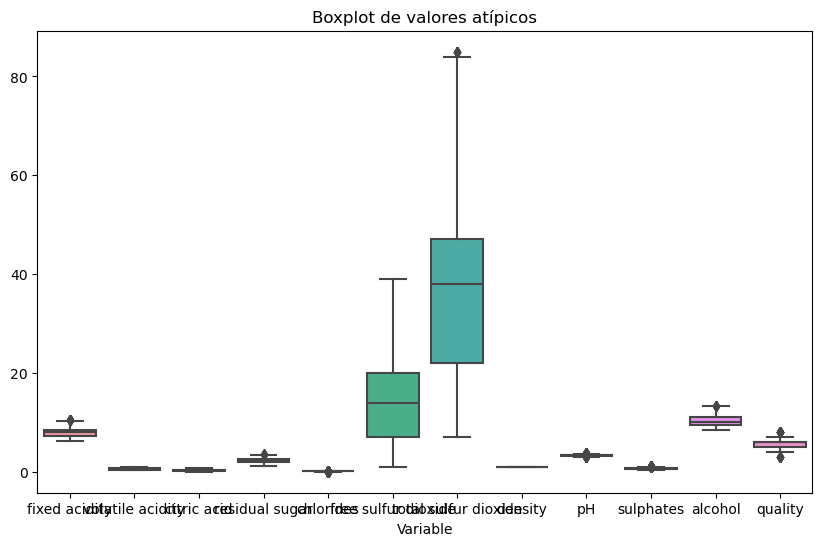

In [48]:
# Observamos nuevamente los velores atipicos
plt.figure(figsize=(10, 6))
#sns.boxplot(data=data.iloc[:, :1])
sns.boxplot(data=data)
plt.title('Boxplot de valores atípicos')
plt.xlabel('Variable')
plt.show()

In [50]:
# Verificamos que no existan valores nulos
# despues de tratar valores atipicos
print(data.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


## Seleccionar Mejores Características

In [52]:
x = data.drop(columns=['quality'])
y = data['quality']

selector= SelectKBest(score_func=f_classif, k=5)
x_new= selector.fit_transform(x, y)

mask= selector.get_support()
selected_features= x.columns[mask]

print("Caracteristicas seleccionadas")
print(selected_features)

Caracteristicas seleccionadas
Index(['volatile acidity', 'citric acid', 'total sulfur dioxide', 'sulphates',
       'alcohol'],
      dtype='object')


## Dividir el Dataset

In [54]:
# Dividimos el dataset en train y test
x_train, x_test, y_train, y_test= train_test_split(x_new, y, test_size=0.2, random_state=42)

print("Tamaño del conjunto de entrenamiento: ", x_train.shape, y_train.shape)
print("Tamaño del conjunto de prueba: ", x_test.shape, y_test.shape)

Tamaño del conjunto de entrenamiento:  (1279, 5) (1279,)
Tamaño del conjunto de prueba:  (320, 5) (320,)


## Tratar Balanceo de Clases

In [56]:
# Aplicamos SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
x_train_res, y_train_res = smote.fit_resample(x_train, y_train)

## Escalar Variables

In [58]:
# Escalamos las variables para un mejor ajuste
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

## Crear Modelo e Identificar Hiperparametros

In [60]:
model= DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
# Entrenamos el modelo con dataos de entrenamiento
grid_search.fit(X_train_scaled, y_train)

print("Mejores hiperparámetros: ", grid_search.best_params_)

Mejores hiperparámetros:  {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


## Verificar resultados con Metricas

In [61]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test_scaled), multi_class='ovr')
report = classification_report(y_test, y_pred)

# Observamos los resultados de las metricas
print(f"Precisión del modelo: {accuracy}")
print(f"ROC AUC: {roc_auc}")
print(report)

Precisión del modelo: 0.59375
ROC AUC: 0.6045776486450487
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.17      0.10      0.12        10
           5       0.68      0.67      0.67       130
           6       0.59      0.61      0.60       132
           7       0.49      0.50      0.49        42
           8       0.00      0.00      0.00         5

    accuracy                           0.59       320
   macro avg       0.32      0.31      0.32       320
weighted avg       0.59      0.59      0.59       320



# Analisis de Resultados

## 1. Evaluación General del Modelo

###    Precisión Global (accuracy): 0.59 (59%). 
Esto indica que el modelo clasifica correctamente aproximadamente el 59% de las muestras en el conjunto de prueba.
###    ROC AUC: 0.60. 
Aunque esta métrica es baja, es normal dado el desequilibrio en las clases y la dificultad para predecir con precisión algunas de las clases minoritarias.

Estos valores sugieren que el modelo tiene un desempeño moderado en general, pero enfrenta dificultades para manejar el desequilibrio en las clases.
## 2. Análisis de las Métricas por Clase

Las métricas de precisión, recall y F1-score por clase nos dan una idea de cómo el modelo maneja cada clase de calidad de vino:

###    Clases con Desempeño Bajo:
Clase 3 y Clase 8: Ambas tienen un recall y F1-score de 0. Esto indica que el modelo no logra identificar ninguna muestra correctamente en estas clases. Esto probablemente se deba a que hay muy pocas muestras para estas clases, lo que dificulta que el modelo aprenda patrones representativos.

Clase 4: Tiene una precisión de 0.17 y un recall de 0.10, con un F1-score bajo de 0.12. Esto muestra que el modelo tiene dificultades para predecir correctamente esta clase, posiblemente también debido al bajo número de muestras (support de 10).

###    Clases con Desempeño Moderado:
Clase 5: Es la mejor predicha, con una precisión de 0.68 y un recall de 0.67, lo cual da un F1-score de 0.67. Esto es un buen indicador de que el modelo logra identificar esta clase de manera relativamente confiable. La mayor cantidad de datos (130 muestras) probablemente permite al modelo capturar mejor sus características.

Clase 6 y Clase 7: Ambas tienen valores moderados, con precisión, recall y F1-scores alrededor de 0.49 a 0.61. Esto indica que el modelo logra predecir estas clases con un rendimiento aceptable, aunque no ideal.

## 3. Promedios Macro y Ponderado

###    Macro Avg:
Tiene un F1-score de 0.32, lo que significa que, en promedio, el modelo tiene un rendimiento bajo en todas las clases si no se consideran las diferencias en la cantidad de muestras por clase. Este valor es bajo porque el modelo no puede predecir bien las clases minoritarias.

###    Weighted Avg:
El F1-score ponderado es 0.59, lo que sugiere un rendimiento razonable si se tienen en cuenta las clases mayoritarias. Este promedio refleja que el modelo se desempeña bien en las clases con más datos (como las clases 5, 6 y 7), pero sigue siendo afectado por las clases con pocos ejemplos.